# Diabetes Prediction with ML Models

The data were collected from the Iraqi society, as they data were acquired from the laboratory of Medical City Hospital and (the Specializes Center for Endocrinology and Diabetes-Al-Kindy Teaching Hospital). Patients' files were taken and data extracted from them and entered in to the database to construct the diabetes dataset. The data consist of medical information, laboratory analysis.

The data consist of medical information, laboratory analysis… etc. The data that have been entered initially into the system are: No. of Patient, Sugar Level Blood, Age, Gender, Creatinine ratio(Cr), Body Mass Index (BMI), Urea, Cholesterol (Chol), Fasting lipid profile, including total, LDL, VLDL, Triglycerides(TG) and HDL Cholesterol , HBA1C, Class (the patient's diabetes disease class may be Diabetic, Non-Diabetic, or Predict-Diabetic).

#  1. Importing Libraries
We begin by importing the required Python libraries for:
- Data manipulation (`pandas`, `numpy`)
- Visualization (`matplotlib`, `seaborn`)
- Machine learning models (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Model evaluation and tuning (`train_test_split`, `RandomizedSearchCV`, metrics)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

import lime
import lime.lime_tabular
import shap


import warnings
warnings.filterwarnings('ignore')

#  2. Data Loading and Exploration
We load the **Diabetes dataset**, check its structure, and perform basic exploratory analysis:
- Preview the data
- Check column info
- Identify missing values

In [2]:
dia_data = pd.read_csv("Diabetes Data.csv")
dia_data.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


In [3]:
dia_data.info()
dia_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  264 non-null    int64  
 1   AGE     264 non-null    int64  
 2   Urea    264 non-null    float64
 3   Cr      264 non-null    int64  
 4   HbA1c   264 non-null    float64
 5   Chol    264 non-null    float64
 6   TG      264 non-null    float64
 7   HDL     264 non-null    float64
 8   LDL     264 non-null    float64
 9   VLDL    264 non-null    float64
 10  BMI     264 non-null    float64
 11  Class   264 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 24.9 KB


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.545455,49.522727,5.671515,85.806818,6.862727,4.594394,2.151894,1.182879,2.530871,1.479167,26.626856,1.121212
std,0.498875,10.127301,4.002837,99.400047,2.544604,1.289062,1.265841,0.455591,1.000173,3.099856,5.093652,0.914857
min,0.000000,25.000000,1.100000,6.000000,0.900000,0.000000,0.600000,0.400000,0.300000,0.200000,19.000000,0.000000
25%,0.000000,43.000000,3.600000,46.000000,5.000000,3.875000,1.300000,0.900000,1.800000,0.675000,23.000000,0.000000
50%,1.000000,50.000000,4.700000,61.000000,6.100000,4.500000,1.800000,1.100000,2.500000,0.900000,25.000000,1.000000
75%,1.000000,55.250000,6.100000,82.250000,8.200000,5.300000,2.725000,1.325000,3.200000,1.300000,30.000000,2.000000
max,1.000000,77.000000,26.400000,800.000000,14.600000,9.500000,8.700000,4.000000,5.600000,31.800000,43.250000,2.000000


In [4]:
# Check for missing data
dia_data.isnull().values.any()

np.False_

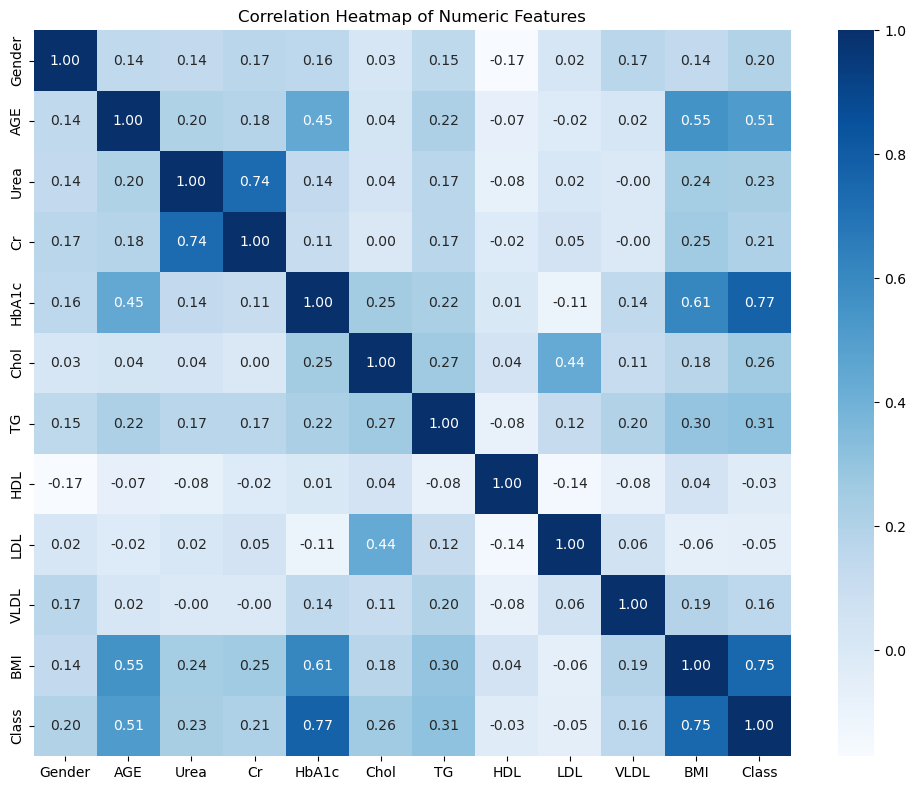

In [5]:
# numeric_cols = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
plt.figure(figsize=(10, 8))
sns.heatmap(dia_data.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# 3. Train-Test Split
We split the dataset into **training** and **test** sets for model training and evaluation.


In [6]:
# Separate features and target variable
X = dia_data.drop('Class', axis=1)  # Features: all columns except the target
y = dia_data['Class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Model Training and Hyperparameter Tuning

## 4.1 🌱 Baseline Random Forest Classifier Model
We first train a simple Random Forest Classifier model with default hyperparameters.

In [8]:
# Initialize a Random Forest classifier with a fixed random state for reproducibility
clf_model = RandomForestClassifier(random_state=42)
# Train the classifier on the training data
clf_model.fit(X_train, y_train)
# Make predictions on the test data
clf_y_pred = clf_model.predict(X_test)

In [9]:
# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, clf_y_pred))
print(classification_report(y_test, clf_y_pred))
print("Accuracy Score:\n", accuracy_score(y_test, clf_y_pred)* 100)

Confusion Matrix:
 [[19  0  0]
 [ 0  8  0]
 [ 1  0 25]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53

Accuracy Score:
 98.11320754716981


## 4.1.1🔧 Hyperparameter Tuning (Random Forest Classifier)

We use **RandomizedSearchCV** to search across multiple hyperparameters for the best Random Forest Classifier model.

In [34]:
# Define parameter grid for RandomForest classifier hyperparameter tuning
clf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
            }

clf_tuned = RandomizedSearchCV(
    estimator=clf_model,           
    param_distributions=clf_param_grid,
    n_iter=10,                     
    scoring='roc_auc',             
    cv=5,                          
    verbose=2,                     
    n_jobs=-1,                     
    random_state=42                
)
# Fit the randomized search to find optimal hyperparameters
clf_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [12]:
# Extract the model with the best parameters found during the search
clf_best_model = clf_tuned.best_estimator_

# Make predictions using the best model
clf_y_pred_2 = clf_best_model.predict(X_test)

# Evaluate model performance
print("\nBest Parameters:", clf_tuned.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, clf_y_pred_2))  
print("\nClassification Report:\n", classification_report(y_test, clf_y_pred_2))  
print("Accuracy Score:\n", accuracy_score(y_test, clf_y_pred_2)* 100)


Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}
Confusion Matrix:
 [[19  0  0]
 [ 0  8  0]
 [ 1  0 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53

Accuracy Score:
 98.11320754716981


## 4.2 🌱 Baseline XGBoost Model
We first train a simple XGBoost model with default hyperparameters.

In [13]:
# Initialize XGBoost classifier with logloss evaluation metric and fixed random state for reproducibility
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
# Train the XGBoost model on the training data
xgb_model.fit(X_train, y_train)
# Make predictions on the test data
xgb_y_pred = xgb_model.predict(X_test)

In [14]:
# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_y_pred))
print("Accuracy Score:\n", accuracy_score(y_test, xgb_y_pred)* 100)

Confusion Matrix:
 [[19  0  0]
 [ 0  8  0]
 [ 1  1 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.89      1.00      0.94         8
           2       1.00      0.92      0.96        26

    accuracy                           0.96        53
   macro avg       0.95      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53

Accuracy Score:
 96.22641509433963


## 4.2.1🔧 Hyperparameter Tuning (XGBoost)

We use **RandomizedSearchCV** to search across multiple hyperparameters for the best XGBoost model.

In [15]:
# Define hyperparameter grid for XGBoost model tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'min_child_weight': [1, 3, 5, 7]
}

xgb_tuned = RandomizedSearchCV(
    estimator=xgb_model,                
    param_distributions= xgb_param_grid,
    n_iter=50,                          
    scoring='roc_auc',                  
    n_jobs=-1,                          
    cv=3,                               
    verbose=2,                          
    random_state=42                     
)

# Fit the randomized search to find optimal hyperparameters
xgb_tuned.fit(X_train, y_train)

In [35]:
# Extract the model with the best parameters found during the search
xgb_best_model = xgb_tuned.best_estimator_

# Make predictions using the best model
xgb_y_pred_2 = xgb_best_model.predict(X_test)

# Evaluate model performance
print("Best Parameters:", xgb_tuned.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred_2))
print("Classification Report:\n", classification_report(y_test, xgb_y_pred_2))
print("Accuracy Score:\n", accuracy_score(y_test, xgb_y_pred_2)* 100)

Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Confusion Matrix:
 [[19  0  0]
 [ 0  8  0]
 [ 1  1 24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.89      1.00      0.94         8
           2       1.00      0.92      0.96        26

    accuracy                           0.96        53
   macro avg       0.95      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53

Accuracy Score:
 96.22641509433963


## 4.3 🌱 Baseline LightGBM Model
We first train a simple LightGBM model with default hyperparameters.

In [18]:
# Initialize LightGBM classifier with fixed random seed for reproducibility
lgbm_model = LGBMClassifier(random_state=42)
# Train the LightGBM model on the training data
lgbm_model.fit(X_train, y_train)
# Make predictions on the test data
lgbm_y_pred = lgbm_model.predict(X_test);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 11
[LightGBM] [Info] Start training from score -1.008053
[LightGBM] [Info] Start training from score -1.886122
[LightGBM] [Info] Start training from score -0.726885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [19]:
# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, lgbm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, lgbm_y_pred))
print("Accuracy Score:\n", accuracy_score(y_test, xgb_y_pred)* 100)

Confusion Matrix:
 [[19  0  0]
 [ 0  7  1]
 [ 0  0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.88      0.93         8
           2       0.96      1.00      0.98        26

    accuracy                           0.98        53
   macro avg       0.99      0.96      0.97        53
weighted avg       0.98      0.98      0.98        53

Accuracy Score:
 96.22641509433963


## 4.3.1🔧 Hyperparameter Tuning (LightGBM)

We use **RandomizedSearchCV** to search across multiple hyperparameters for the best LightGBM model.

In [20]:
# Define hyperparameter grid for LightGBM model tuning
lgbm_param_grid = {
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 1000],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm_tuned = RandomizedSearchCV(
    estimator=lgbm_model,                
    param_distributions=lgbm_param_grid, 
    n_iter=50,                           
    scoring='roc_auc',                   
    cv=3,                                
    verbose=1,                          
    n_jobs=-1,                           
    random_state=42                      
)

# Train the model with the different parameter combinations on the training data
lgbm_tuned.fit(X_train, y_train)

In [22]:
# Extract the model with the best parameters found during the search
lgbm_best_model = lgbm_tuned.best_estimator_

# Make predictions using the best model
lgbm_y_pred_2 = lgbm_best_model.predict(X_test)

# Evaluate model performance
print("Best Parameters:", lgbm_tuned.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, lgbm_y_pred_2))  
print("Classification Report:\n", classification_report(y_test, lgbm_y_pred_2))  
print("Accuracy Score:\n", accuracy_score(y_test, lgbm_y_pred_2)* 100)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        26

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Confusion Matrix:
 [[19  0  0]
 [ 0  8  0]
 [ 0  0 26]]
Accuracy Score:
 100.0


#  5. Model Interpretability: LIME
LIME provides **local explanations** by approximating the model around a single prediction 
using a simple surrogate model.  
This is useful for **explaining individual predictions** in a human-readable way.


In [28]:
# Create a Lime explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns,
    class_names = ['No Diabetes','Diabetes', 'Predict Diabetes'],
    mode='classification'
)

# Explain a single prediction (first test sample)
i = 0
exp = lime_explainer.explain_instance(
    data_row = X_test.iloc[i].values,
    predict_fn = lgbm_best_model.predict_proba
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)


#  6. Model Interpretability: SHAP
To understand **why the model makes predictions**, we use **SHAP**:
- **Bar Plot:** Shows global feature importance
- **Beeswarm Plot:** Shows how features affect predictions

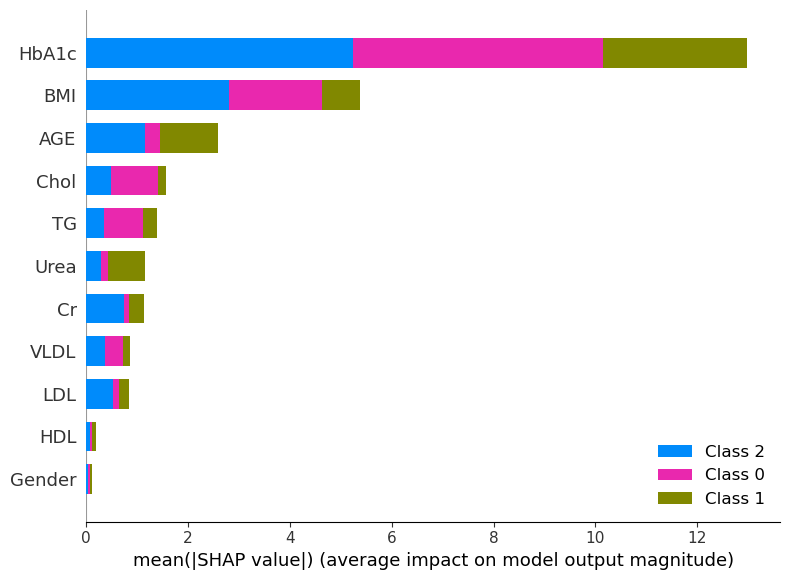

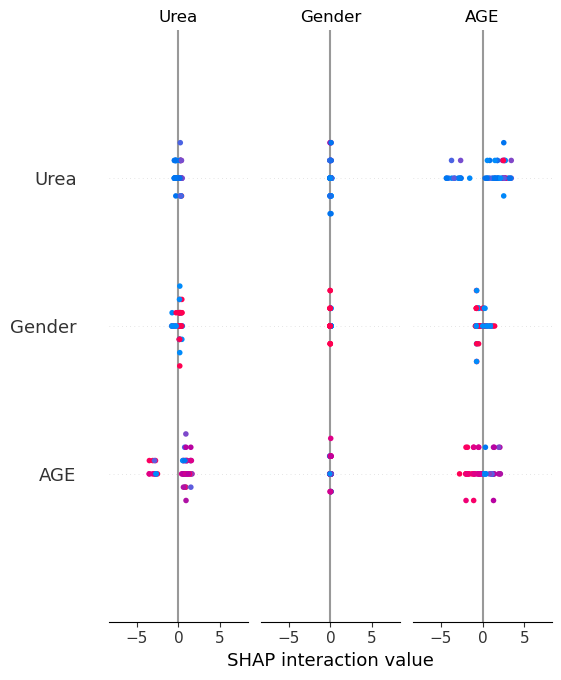

In [24]:
explainer = shap.TreeExplainer(lgbm_best_model)
shap_values = explainer.shap_values(X_test)

# Global summary (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Global summary (beeswarm)
shap.summary_plot(shap_values, X_test)


# 7. Feature Importances

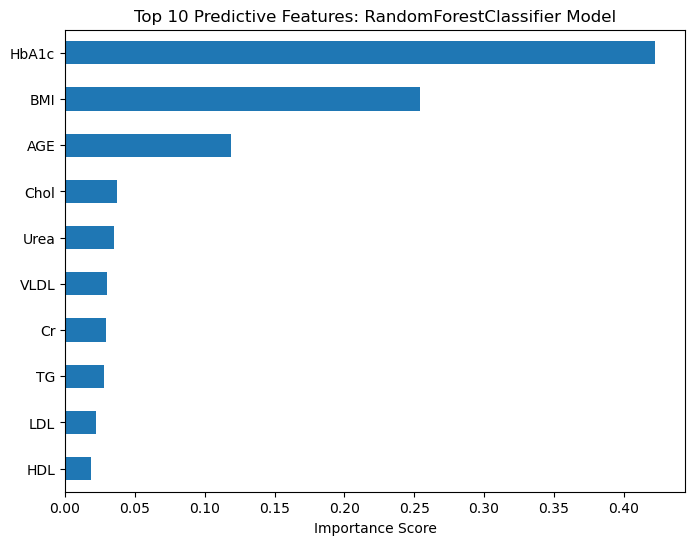

In [25]:
# Extract feature importances from the classifier model and store them in a pandas Series with feature names as index
importances = pd.Series(clf_model.feature_importances_, index=X.columns)

# Select the 10 most important features, sort them by value, and create a horizontal bar chart
importances.nlargest(10).sort_values().plot(kind='barh', figsize=(8,6), title="Top 10 Predictive Features: RandomForestClassifier Model")

# Add a label to the x-axis
plt.xlabel("Importance Score")

# Display the plot
plt.show()

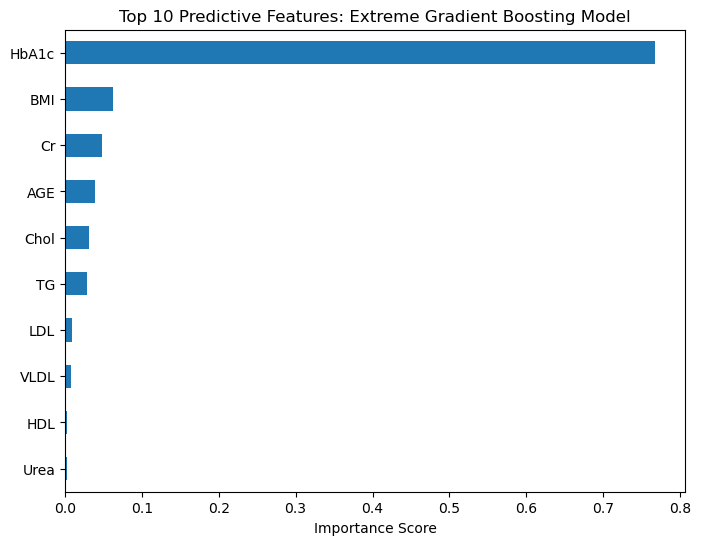

In [26]:
# Create a Series containing feature importances from the XGBoost model
importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Plot the top 10 most important features as a horizontal bar chart
importances_xgb.nlargest(10).sort_values().plot(kind='barh', figsize=(8,6), title="Top 10 Predictive Features: Extreme Gradient Boosting Model")

# Add a label to the x-axis
plt.xlabel("Importance Score")

# Display the plot
plt.show()

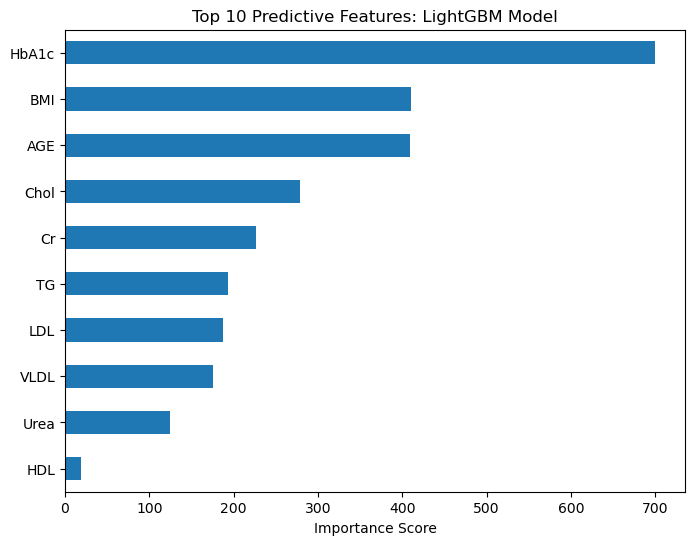

In [27]:
# Create a Series of feature importances from the LightGBM model, with feature names as index
importances_lgbm = pd.Series(lgbm_model.feature_importances_, index=X.columns)

# Select the 10 most important features, sort them in ascending order, and create a horizontal bar plot
importances_lgbm.nlargest(10).sort_values().plot(kind='barh', figsize=(8,6), title="Top 10 Predictive Features: LightGBM Model")

# Add a label for the x-axis
plt.xlabel("Importance Score")

# Display the plot
plt.show()

## 7.1 Best Model Feature Importances (Tuned LightGBM model-100% accuracy score)

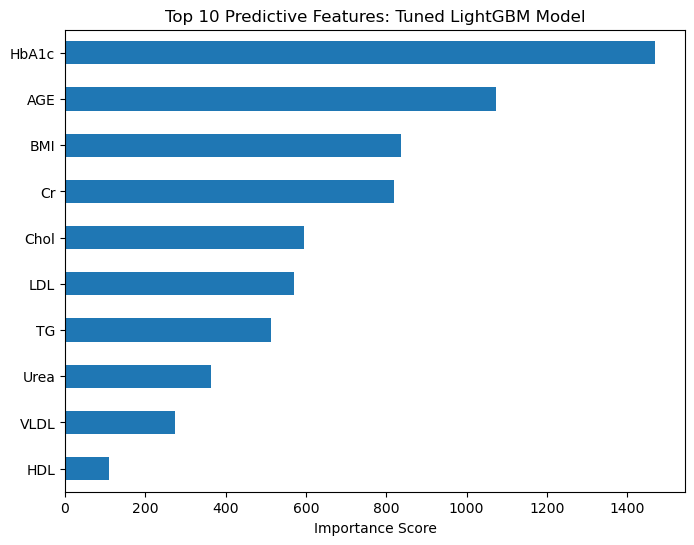

In [37]:
# Create a Series of feature importances from the tuned LightGBM model, with feature names as index
importances_lgbm_best_model = pd.Series(lgbm_best_model.feature_importances_, index=X.columns)

# Select the 10 most important features, sort them in ascending order, and create a horizontal bar plot
importances_lgbm_best_model.nlargest(10).sort_values().plot(kind='barh', figsize=(8,6), title="Top 10 Predictive Features: Tuned LightGBM Model")

# Add a label for the x-axis
plt.xlabel("Importance Score")

# Display the plot
plt.show()

# 8. 🏁 Conclusion

- The **tuned LightGBM model** achieved strong performance on diabetes prediction (100% accuracy score).  
- **SHAP analysis** showed which features most strongly drive predictions (globally and per patient).  
- **LIME explanations** helped verify individual patient predictions in a human-friendly way.  